# Exploratory Data Analysis

A bit of EDA was conducted to understand and gain insights on what features were predictive of user scores, what words were telling of user sentiments and what differences there were in reviews among game genres. Initiallly, different features of the clean text reviews were explored and word clouds for the most predictive words for sentiment were created. Then the data was explored to uncover the differences presented among game reviews by their genre. 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load data
df = pd.read_csv('MetacriticGameReviewsClean.csv', index_col=0)

# Change the genre of shoot to shooter
df['genre'] = df.genre.replace('Shoot', 'Shooter')

df.head()

,title,platform,metascore,metasentiment,average_userscore,average_usersentiment,developer,genre,number_of_players,esrb_rating,...,reading_level,syllable_count,POS_tagged,conjunction_count,adjective_count,noun_count,pronoun_count,adverb_count,verb_count,other_POS_count
0,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,...,60.55,254,"[('the', 'DT'), ('main', 'JJ'), ('problem', 'N...",11,35,43,13,13,25,38
1,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,...,60.69,118,"[('it', 'PRP'), ('is', 'VBZ'), ('not', 'RB'), ...",4,6,22,4,2,18,23
2,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,...,60.89,495,"[('visually', 'RB'), ('superb', 'JJ'), ('excep...",19,41,83,28,35,65,80
3,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,...,76.15,459,"[('great', 'JJ'), ('looking', 'VBG'), ('game',...",9,28,73,25,37,81,99
4,Red Dead Redemption 2,Xbox One,97.0,positive,7.8,positive,Rockstar Games,Action adventure,multiplayer,M,...,67.49,820,"[('red', 'JJ'), ('dead', 'JJ'), ('redemption',...",26,44,128,35,72,132,177


## How are the user review scores distributed in the data?
***

Text(0, 0.5, 'Percentage')

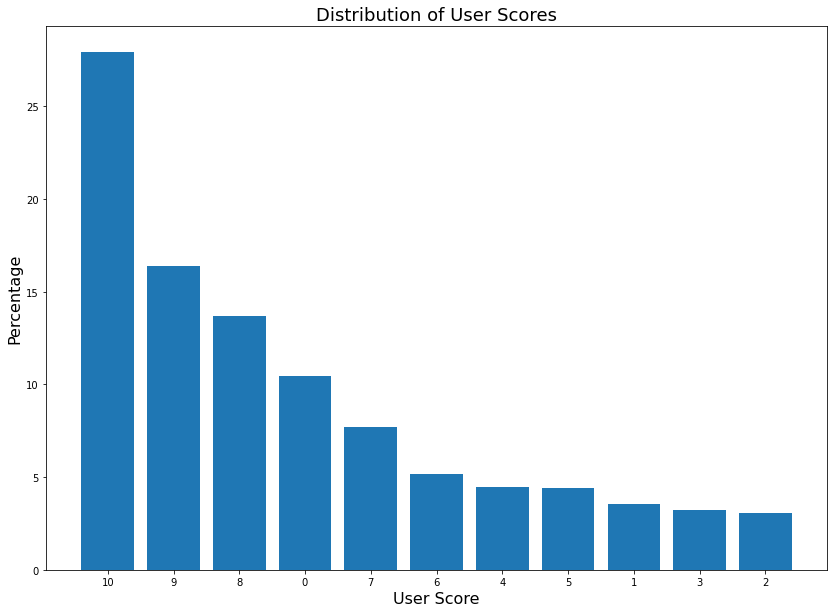

In [2]:
# Get percentage of scores from users
percent_userscore = [round(val*100, 2) for val in df.userscore.value_counts(normalize=True).values]
score = [str(i) for i in df.userscore.value_counts().index]

# Plot the distribution of number of words by user score for each game genre
plt.figure(figsize=(14,10))
plt.bar(x=score, height=percent_userscore)
plt.title('Distribution of User Scores', fontsize=18)
plt.xlabel('User Score', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

Most of the reviews in the dataset were positive accounting for about 57% of the total reviews. A whopping 10% of all reviews received a 0. People tend to enjoy video games released on console or they tend to be easily pleased with the attributes game developers add to their games.<br><br>

## Are positive user reviews longer than negative ones?
***

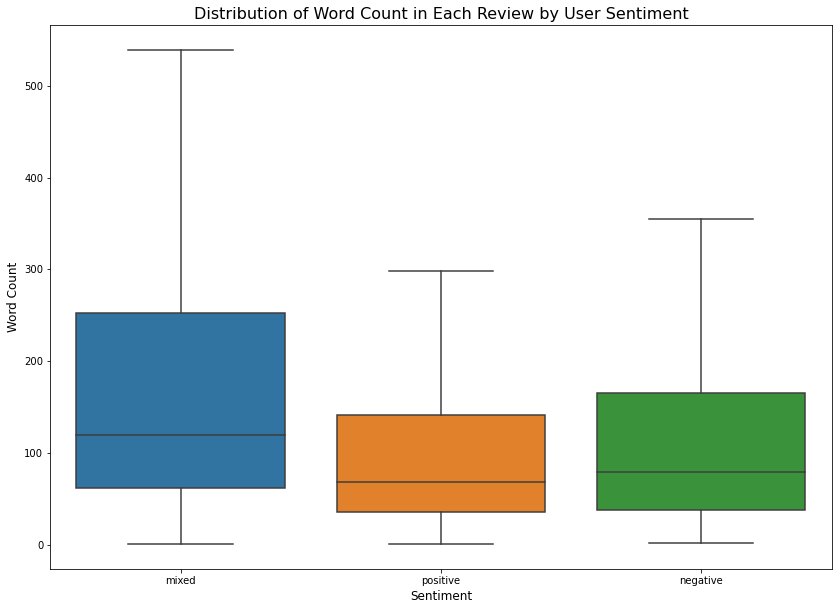

In [3]:
# Plot the distribution of number of words by user score for each game genre
plt.figure(figsize=(14,10))
ax = sns.boxplot(x='usersentiment', y='word_count', data=df, showfliers=False)
ax.set_title('Distribution of Word Count in Each Review by User Sentiment',  fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.show()

In [4]:
# Initialize a list of user sentiment
sentiments = df.usersentiment.value_counts().index

# Loop through each genre and test for normality
for sent in sentiments:
    subset = df[df.usersentiment == sent]['word_count'].values

    # Check for normal distribution to then use ANOVA testing
    k2, p = ss.normaltest(subset)
    alpha = 1e-3
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected. Word count is not normally distributed in", sent, "reviews.")
    else:
        print("The null hypothesis cannot be rejected. Word count is normally distributed in", sent, "reviews.")

p = 0
The null hypothesis can be rejected. Word count is not normally distributed in positive reviews.
p = 0
The null hypothesis can be rejected. Word count is not normally distributed in negative reviews.
p = 5.94275e-261
The null hypothesis can be rejected. Word count is not normally distributed in mixed reviews.


On average reviews where the user had mixed feelings about a game, encompass the most words among all reviews. This could be due to the gamer expressing what he enjoyed in the game and what he disliked. Using more words allows reviews with mixed feelings toward a game vividly expressed why they were experienced conflicting emotions. <br>

Positive reviews were generally the shortest type of reviews with the average positive review having somewhere between 70 and 90 words. One can imagine these reviews highlight the best features of the game and short summaries as to why the game was so enjoyable. The negative reviews may have been written in similar fashion. Perhaps accounting for the larger number of word usage from positive reviews, with additional excerpts explaining how the game could be improved.

## Which is the most common part of speech among positive and negative reviews? Do positive reviews have more adjectives in them than negative ones?
***

(-5.0, 100.0)

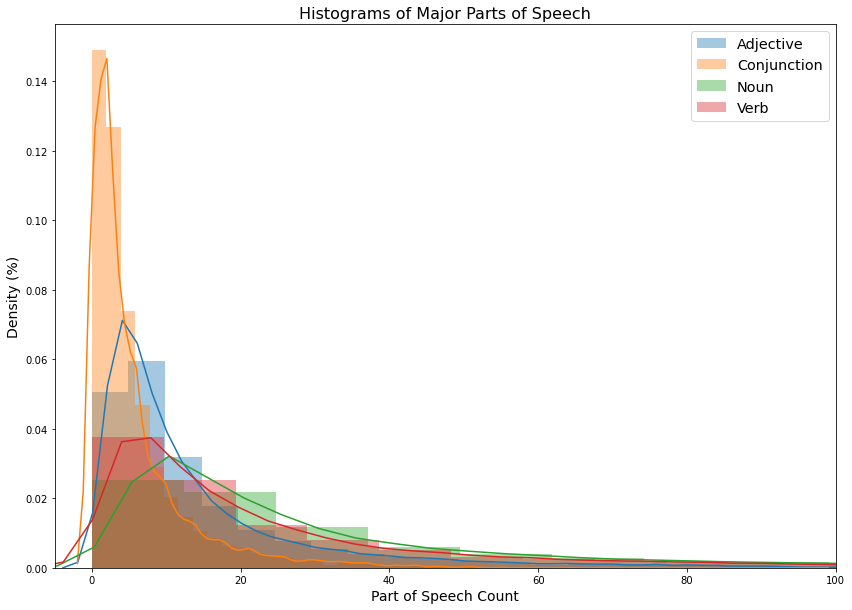

In [5]:
# Plot the distributions of the POS counts in the data
plt.figure(figsize=(14,10))
sns.distplot(df.adjective_count, label='Adjective')
sns.distplot(df.conjunction_count, label='Conjunction')
sns.distplot(df.noun_count, label='Noun')
sns.distplot(df.verb_count, label='Verb')
plt.legend(loc='upper right', fontsize='x-large')
plt.title('Histograms of Major Parts of Speech', fontsize=16)
plt.xlabel('Part of Speech Count', fontsize=14)
plt.ylabel('Density (%)', fontsize=14)
plt.xlim(left=-5,right=100)

All distributions for the different major parts of speech in the data are right skewed. To approximate a normal distribution of each POS, the mean of various iterations of bootstrapped samples were collected.

In [6]:
from sklearn.utils import resample

def bootstrap_avg(array, bootstrap_samples=100000, pct_of_resample=0.95):
    ''' Resamples an array multiple times and returns an average for each of the resamples. '''
    try:
        bs_avg = []
        for i in range(bootstrap_samples):
            sample = resample(array, n_samples=round(len(array)*pct_of_resample))
            bs_avg.append(sample.mean())
        return bs_avg
    except:
        print('Resample size should be a percentage between 0 and 1.')

In [7]:
# Seperate POS counts into two dataframes one for positive reviews and the other for negative reviews
pos_POS = df[df['usersentiment'] == 'positive'].loc[:,['conjunction_count','adjective_count','verb_count','noun_count']]
neg_POS = df[df['usersentiment'] == 'negative'].loc[:,['conjunction_count','adjective_count','verb_count','noun_count']]

# For each POS use bootstrap avg function to get a normal distribution of average POS counts for hypothesis testing
pos_conj_bs = bootstrap_avg(pos_POS.conjunction_count)
neg_conj_bs = bootstrap_avg(neg_POS.conjunction_count)

pos_adj_bs = bootstrap_avg(pos_POS.adjective_count)
neg_adj_bs = bootstrap_avg(neg_POS.adjective_count)

pos_verb_bs = bootstrap_avg(pos_POS.verb_count)
neg_verb_bs = bootstrap_avg(neg_POS.verb_count)

pos_noun_bs = bootstrap_avg(pos_POS.noun_count)
neg_noun_bs = bootstrap_avg(neg_POS.noun_count)

Text(0, 0.5, 'Density (%)')

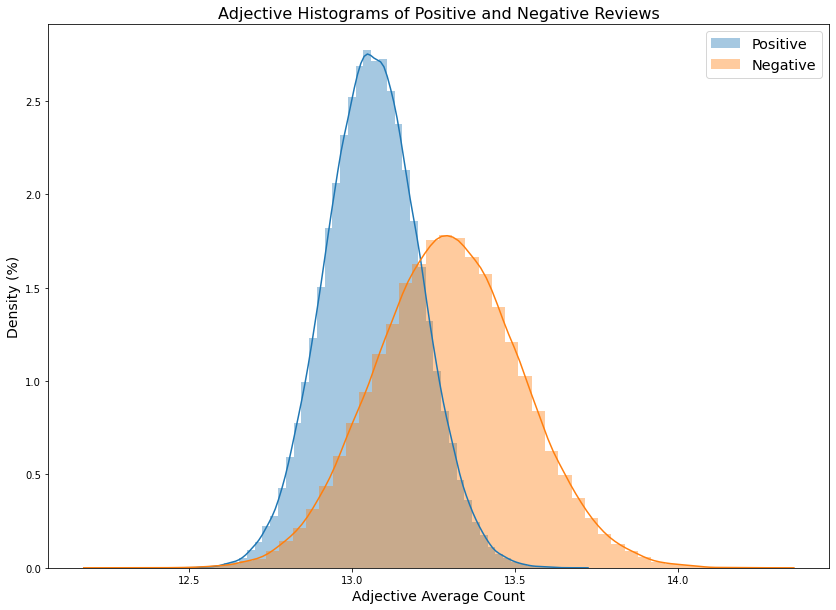

In [8]:
# Plot the distributions of the POS counts in the data
plt.figure(figsize=(14,10))
sns.distplot(pos_adj_bs, label='Positive')
sns.distplot(neg_adj_bs, label='Negative')
plt.legend(loc='upper right', fontsize='x-large')
plt.title('Adjective Histograms of Positive and Negative Reviews', fontsize=16)
plt.xlabel('Adjective Average Count', fontsize=14)
plt.ylabel('Density (%)', fontsize=14)

In the example of adjective histograms of positive and negative reviews, the distributions now resemble a normal distribution. This can help us now test our hypothesis of whether if there are indeed more adjectives among positive reviews than negative ones and if the difference even is significant. 

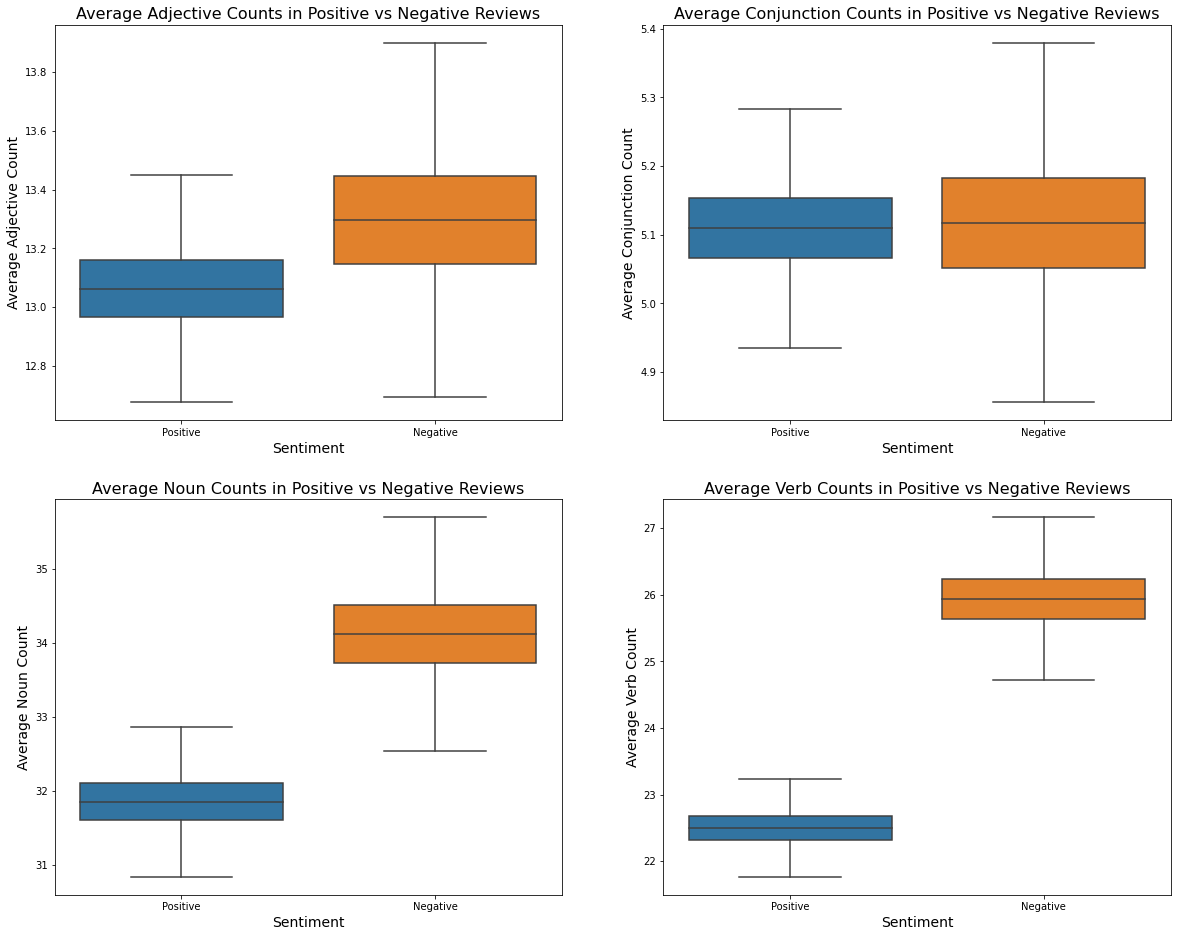

In [9]:
# Pack positive and negative POS bootstrapped averages to one variable for looping
adj_bs = (pos_adj_bs, neg_adj_bs)
conj_bs = (pos_conj_bs, neg_conj_bs)
noun_bs = (pos_noun_bs, neg_noun_bs)
verb_bs = (pos_verb_bs, neg_verb_bs)

# Create a list of POS bootstrapped averages and strings of POS
POS_bs_avgs = [adj_bs, conj_bs, noun_bs, verb_bs]
POS = ['Adjective', 'Conjunction', 'Noun', 'Verb']

plt.figure(figsize=(20,16))
# Loop over POS bootstrapped averages list to plot and compare positive and negative reviews
for i, bs in enumerate(POS_bs_avgs):
    # Unpack tuple of list of bootstrapped averages for the given POS
    pos_POS_bs, neg_POS_bs = bs

    # Join positive and negative bootstrapped lists into a dataframe for plotting
    pos_df = pd.DataFrame({'Average_'+POS[i]+'_Count':pos_POS_bs})
    pos_df['Sentiment'] = 'Positive'
    neg_df = pd.DataFrame({'Average_'+POS[i]+'_Count':neg_POS_bs})
    neg_df['Sentiment'] = 'Negative'
    bs_POS_df = pd.concat([pos_df, neg_df], axis=0)
    
    # Plot boxplots comparing each POS to its positive and negative review counterpart
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x='Sentiment', y='Average_'+POS[i]+'_Count', data=bs_POS_df, showfliers=False)
    ax.set_title('Average '+POS[i]+' Counts in Positive vs Negative Reviews',  fontsize=16)
    plt.xlabel('Sentiment', fontsize=14)
    plt.ylabel('Average '+POS[i]+' Count', fontsize=14)
    
plt.show()

In [10]:
# Perform a t-test and calculate p-values to verify if there is a statistically significant difference among POS count in positive and negative reviews
for i, bs in enumerate(POS_bs_avgs):
    # Unpack tuple of list of bootstrapped averages for the given POS
    pos_POS_bs, neg_POS_bs = bs
    stat, p = ss.ttest_ind(pos_POS_bs, neg_POS_bs) 
    
    if p < 0.05: # Using 95% confidence interval, can be adjusted for different values
        print("There is a statistically significant difference in average "+POS[i].lower()+" count among positive and negative reviews.\nP-value:{p}.\n".format(p =p))
    else:
        print("No statistical significant difference in average "+POS[i].lower()+" count was determined.")
        print(p,'\n')

There is a statistically significant difference in average adjective count among positive and negative reviews.
P-value:0.0.

There is a statistically significant difference in average conjunction count among positive and negative reviews.
P-value:7.805365539990207e-111.

There is a statistically significant difference in average noun count among positive and negative reviews.
P-value:0.0.

There is a statistically significant difference in average verb count among positive and negative reviews.
P-value:0.0.



On average negative reviews contain more of all parts of speech in comparison to positive reviews. With verbs occurring much more in negative reviews than positive ones among all parts of speech looked at. Although conjunctions appear slightly more in negative reviews, a similar average of conjunctions are also found in positive reviews. However, among the parts of speeched examined conjunctions are the least expressive of the group.

## What are the most predictive words in game reviews by sentiment?
***

In [11]:
# Create term document matrix of all words with CountVectorizer
reviews = df.clean_text
cv = CountVectorizer(min_df=0.02, max_df=0.99)
tdm = cv.fit_transform(reviews)
words = np.array(cv.get_feature_names())

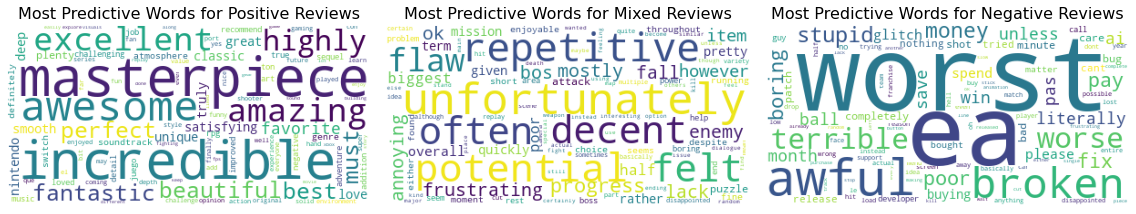

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Assign term document matrix to variable X to use as predictors for model to find most predictive words
X = tdm

# Initialize a list of the different user sentiments
sentiments = ['positive', 'mixed', 'negative']

# Initialize a WordCloud processor to generate word clouds
wc = WordCloud(background_color='white', random_state=1, max_words=100)
plt.rcParams['figure.figsize'] = [16, 6]

# Loop over each sentiment and assign it as the target variable in mulinomial naive bayes model
# Using the trained model of mostly all words find the probability of each word indicating the
# the specific sentiment by predicting on an identity matrix of the words used to train the model
for i,sent in enumerate(sentiments, start=1):
    y = [1 if val == sent else 0 for val in df.usersentiment]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    model = MultinomialNB().fit(X_train, y_train)
    
    x = np.eye(X_test.shape[1])
    probs = model.predict_log_proba(x)[:, 1]
    ind = np.argsort(probs)
    predictive_words = {words[i]:np.exp(probs[i]) for i in ind}
    
    # Create a subplot for each genre's word cloud
    wc.generate_from_frequencies(predictive_words)        
    plt.subplot(1,3,i)
    plt.imshow(wc) 
    plt.axis("off") 
    plt.tight_layout(pad = 1.5)
    plt.title("Most Predictive Words for " + sent.title() + " Reviews", fontsize=16)

plt.show()

Positive reviews were littered with positive words, all indicative of a content reviewer. On the other hand, negative reviews were pretty harsh and mentioned a game developer EA. EA being a predictive word of negative reviews can indicate that sport games developed by EA left gamers with a sense of dissapointment and frustration. Mixed reviews consisted of words that indicate annoyance or underwhelming feelings such as disappointing, average, mediaocre and lacking.

## Are some game genres received better than others?
***

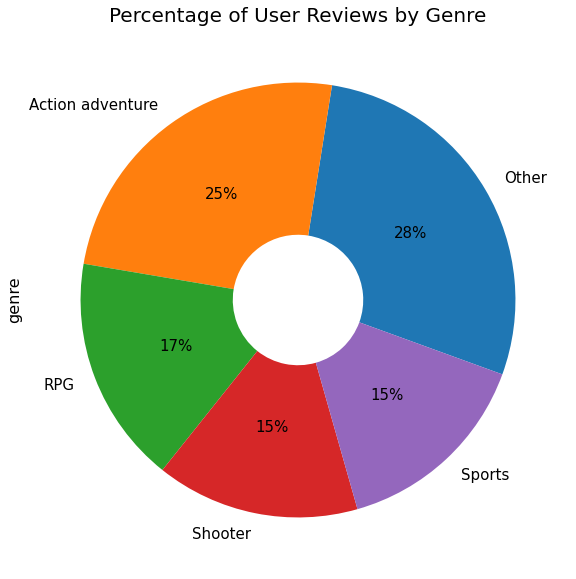

In [13]:
# Plot distribution of user reviews by genre as a pie chart
plt.figure(figsize=(20,10))
plt.title("Percentage of User Reviews by Genre", fontsize=20)
plt.ylabel('Genre',fontsize=16)
df.genre.value_counts().plot(kind='pie', labels=['Other','Action adventure','RPG','Shooter','Sports'],
                                     wedgeprops=dict(width=.7), autopct='%1.0f%%',
                                     startangle= -20, textprops={'fontsize': 15})

Reviews for genres other than action adventure, role-playing games, shooters and sports account for the majority of the reviews consisting of 28% of the data. The aforementioned genres do not trail far behind with a healthy amount of representation for each.

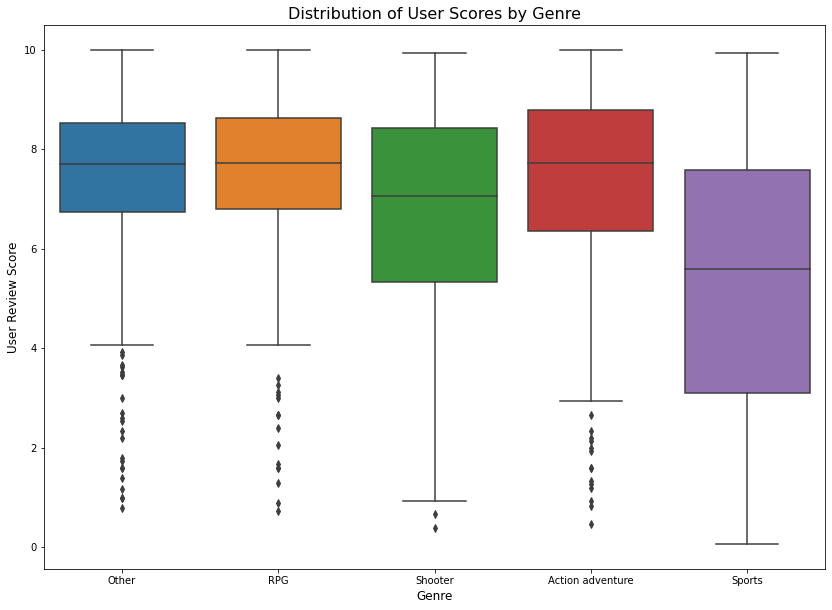

In [14]:
# Group by title and average out the user scores for all titles
titles = df.loc[:,['title','userscore']]
titles = titles.groupby('title').mean()

# Retrieve corresponding genre for all game titles
genre_to_title = []
for t in titles.index:
    g = pd.unique(df.loc[df.title == t]['genre'])[0]
    genre_to_title.append(g)

# Add the genres to group by dataframe
titles['genre'] = genre_to_title

# Plot spread of user scores by genre
plt.figure(figsize=(14,10))
ax = sns.boxplot(x='genre', y='userscore', data=titles)
ax.set_title('Distribution of User Scores by Genre',  fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('User Review Score', fontsize=12)
plt.show()

In [15]:
# Initialize a list of the game genres
genres = df.genre.value_counts().index

# Loop through each genre and test for normality
for genre in genres:
    subset = titles[titles.genre == genre]['userscore'].values

    # Check for normal distribution to then use ANOVA testing
    k2, p = ss.normaltest(subset)
    alpha = 1e-3
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected.", genre, " is not normally distributed.")
    else:
        print("The null hypothesis cannot be rejected.", genre, " is normally distributed.")

p = 3.30267e-17
The null hypothesis can be rejected. Other  is not normally distributed.
p = 1.08435e-11
The null hypothesis can be rejected. Action adventure  is not normally distributed.
p = 1.65138e-09
The null hypothesis can be rejected. RPG  is not normally distributed.
p = 0.00166095
The null hypothesis cannot be rejected. Shooter  is normally distributed.
p = 1.3511e-08
The null hypothesis can be rejected. Sports  is not normally distributed.


Only the sports genre resembled a normal distribution in its scores, hence ANOVA testing for statistical differences among genres could not be performed. However, it is evident most game genres are received well by the average user. The spread of user scores among action adventure games, RPG games and games from lesser known genres is almost indistinguishable with relatively positive scores.

## How are sigleplayer games received by gamers than multiplayer games in each genre?
***

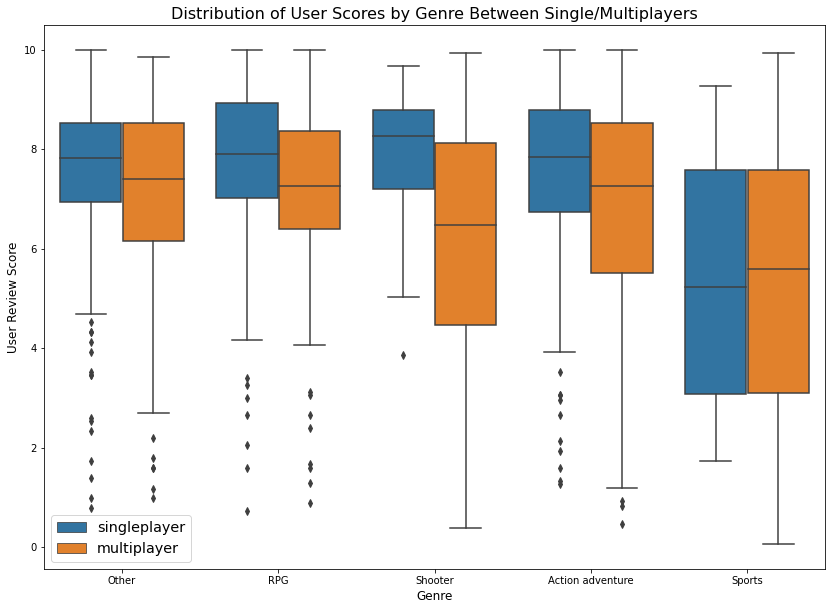

In [16]:
# Retrieve corresponding number of players for all game titles
number_of_players_to_title = []
for t in titles.index:
    n = pd.unique(df.loc[df.title == t]['number_of_players'])[0]
    number_of_players_to_title.append(n)

# Add number_of_players to group by dataframe
titles['number_of_players'] = number_of_players_to_title

# Compare singleplayer user score reviews vs multiplayer games
plt.figure(figsize=(14,10))
ax = sns.boxplot(x='genre', y='userscore', hue='number_of_players', data=titles)
ax.set_title('Distribution of User Scores by Genre Between Single/Multiplayers',  fontsize=16)
plt.legend(fontsize='x-large')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('User Review Score', fontsize=12)
plt.show()

In [17]:
# Calculate p-values through t-testing to verify whether there is a statistical difference between
# single/multiplayer games and the user's review score in the sports genre
single = titles.loc[titles['genre'] == 'Sports', 'userscore'][titles.number_of_players == 'singleplayer']
multi = titles.loc[titles['genre'] == 'Sports', 'userscore'][titles.number_of_players == 'multiplayer']

stat, p = ss.ttest_ind(single, multi) 

if p < 0.05: # Using 95% confidence interval, can be adjusted for different values
    print("There is a statistically significant difference between multi and single player games and user scores in the sports genre.\nP-value:{p}.\n".format(p =p))
else:
    print("The sports genre is not statistically significant between multi and single player games and user scores.")
    print('P-value:',p,'\n')

The sports genre is not statistically significant between multi and single player games and user scores.
P-value: 0.9999228078283705 



In [18]:
# Collect 5 positive and negative, single and multiplayer reviews
pos_single_reviews = list(df.loc[(df['genre'] == 'Shooter') & (df['usersentiment'] == 'positive') & (df['number_of_players'] == 'singleplayer')].review.head())
neg_single_reviews = list(df.loc[(df['genre'] == 'Shooter') & (df['usersentiment'] == 'negative') & (df['number_of_players'] == 'singleplayer')].review.head())
pos_multi_reviews = list(df.loc[(df['genre'] == 'Shooter') & (df['usersentiment'] == 'positive') & (df['number_of_players'] == 'multiplayer')].review.head())
neg_multi_reviews = list(df.loc[(df['genre'] == 'Shooter') & (df['usersentiment'] == 'negative') & (df['number_of_players'] == 'multiplayer')].review.head())


print('\033[1m' + 'Positive singleplayer review for the shooter genre:' + '\033[0m')
print('\t', pos_single_reviews[1], '\n\n')

print('\033[1m' + 'Positive multiplayer review for the shooter genre:' + '\033[0m')
print('\t', pos_multi_reviews[0], '\n\n')

print('\033[1m' + 'Negative singleplayer review for the shooter genre:' + '\033[0m')
print('\t', neg_single_reviews[1], '\n\n')

print('\033[1m' + 'Negative multiplayer review for the shooter genre:' + '\033[0m')
print('\t', neg_multi_reviews[1], '\n\n')

Positive singleplayer review for the shooter genre:
	 I was tired of shooters because last gen we got too many but I really liked this one Single playing gaming at it's finest..........I really recommend it if you like FPS 


Positive multiplayer review for the shooter genre:
	 This game would have got more praise from the public if it was a little cheaper but quite rightly a lot of people are complaining that it's effectively a full price game without the full package, i.e a campaign. However it is an absolutely epic shooter, it allows people to jump straight in and have fun without having to unlock this weapon/peak etc. It can be as simplistic or competitive as the community makes it, my only fear is the console generation will become bored of it very quickly, I suspect the PC community will truly embrace it for what it is. Overall it runs fantastically well, looks good and most of all is fun! 


Negative singleplayer review for the shooter genre:
	 After paying 60$ for this masterpi

Games in every genre except sport games received higher user scores for singlplayer games versus multiplayer games. Sport games, the only genre with normally distributed scores, showed no evidence of a statistical difference between single and multiplayer games. From the example reviews, both positive and negative multiplayer shooter games, felt that the game did not encompass enough features to be considered a full game.

## Does ESRB rating affect how gamers score games based on a game's genre?
***

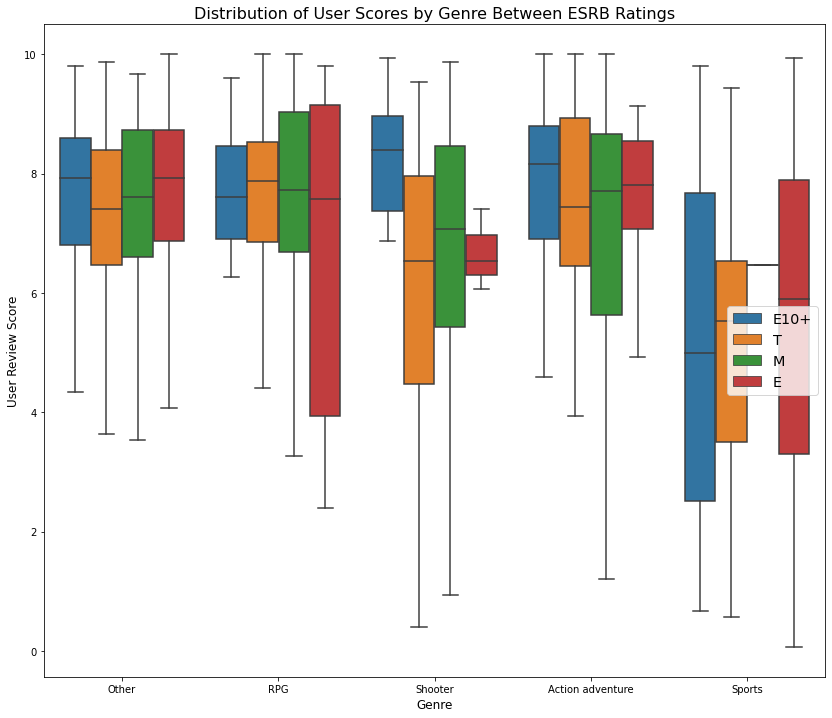

In [19]:
# Retrieve corresponding esrb rating for all game titles
esrb_to_title = []
for t in titles.index:
    n = pd.unique(df.loc[df.title == t]['esrb_rating'])[0]
    esrb_to_title.append(n)

# Add esrb ratings to group by dataframe
titles['esrb_rating'] = esrb_to_title

# Compare singleplayer user score reviews vs multiplayer games
plt.figure(figsize=(14,12))
ax = sns.boxplot(x='genre', y='userscore', hue='esrb_rating', data=titles, showfliers=False)
ax.set_title('Distribution of User Scores by Genre Between ESRB Ratings',  fontsize=16)
plt.legend(fontsize='x-large')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('User Review Score', fontsize=12)
plt.show()

ESRB ratings do not show too much of an affect on user review scores in 'Other', RPG and action adventure genres. Where a big difference is evident is among rated E10+ shooter games. These games are generally always reviewed with positive scores among reviewers, perhaps due to an age group that is completely envoleped with those type of games. Also the tendency to receive lower review scores is reflected throughout all ESRB ratings of sport games, with very few titles in generall being rated as mature.

## What are the most predictive words in game reviews by genre?
***

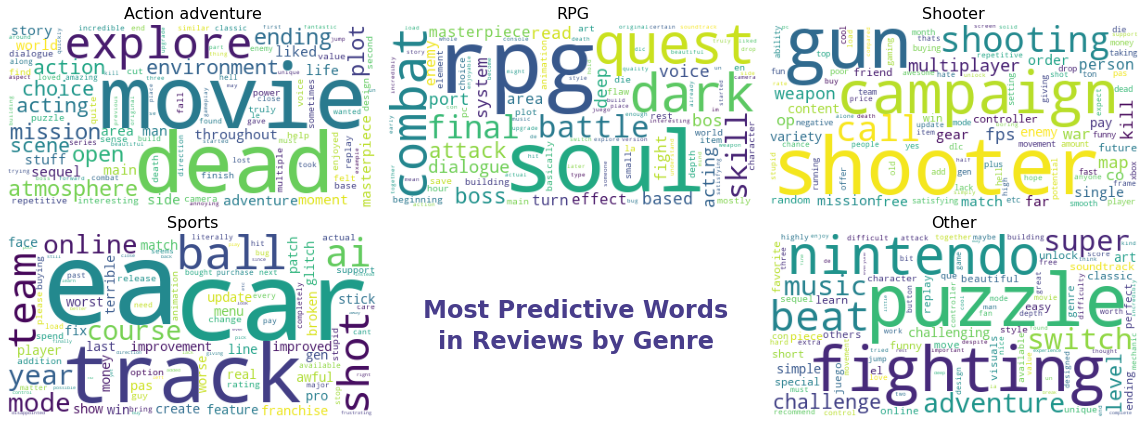

In [20]:
genres = ['Action adventure', 'RPG', 'Shooter', 'Sports', 'Other']

# Create iterator objects for subplot
genre = iter(genres)

plt.rcParams['figure.figsize'] = [16, 6]

# Create a subplot for each genre's word cloud
for i in range(1,7):
    if i == 5:
        plt.subplot(2,3,i)
        plt.text(0.095, 0.55, 'Most Predictive Words', fontsize=24, fontweight='bold', color='darkslateblue')
        plt.text(0.135, 0.385, 'in Reviews by Genre', fontsize=24, fontweight='bold', color='darkslateblue')
        plt.axis("off")
        plt.tight_layout(pad=1)
    else:
        g = next(genre)
        y = [1 if cat == g else 0 for cat in df.genre]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        model = MultinomialNB().fit(X_train, y_train)

        x = np.eye(X_test.shape[1])
        probs = model.predict_log_proba(x)[:, 1]
        ind = np.argsort(probs)
        predictive_words = {words[i]:np.exp(probs[i]) for i in ind}
        
        wc.generate_from_frequencies(predictive_words)        
        plt.subplot(2,3,i)
        plt.imshow(wc) 
        plt.axis("off") 
        plt.tight_layout(pad = 1)
        plt.title(g, fontsize=16)

plt.show()

Action adventure games consist of words that align with story telling aspects such as 'story', 'plot', 'ending', 'movie' and 'atmosphere'. Not surprisignly RPG games are very well described by words in its word cloud. 'Dungeon', 'monster', 'quest', 'crafting' are just some of the few words that are common aspects of RPGs. Most of the genres showcased words very specific to their genres. In the 'Other' genre word cloud many of the words were indicative of other lesser known genres such as platformer, puzzle games, fighting games, and simulator games.

## What are the most predictive words in game reviews by genre and sentiment?
***

In [ ]:
cv = CountVectorizer(min_df=0.02, max_df=0.99, ngram_range=(1,2))
X = cv.fit_transform(reviews)
words = np.array(cv.get_feature_names())

# Instantiate list of genres and sentiments in dataframe
lst_genres = list(df.genre)
lst_sents = list(df.usersentiment)

# Reinstantiate iterator object for subplots
genre = iter(genres)
plt.rcParams['figure.figsize'] = [16, 6]

# Create a subplot for each positive genre review's word cloud
for i in range(1,7):
    if i == 5:
        plt.subplot(2,3,i)
        plt.text(0.095, 0.55, 'Most Predictive Words', fontsize=24, fontweight='bold', color='darkslateblue')
        plt.text(0.015, 0.385, 'in Positive Reviews by Genre', fontsize=22, fontweight='bold', color='darkslateblue')
        plt.axis("off")
        plt.tight_layout(pad=1)
    else:
        g = next(genre)
        y = []
        for idx in range(len(df)):
            if lst_genres[idx] == g and lst_sents[idx] == 'positive':
                y.append(1)
            else:
                y.append(0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        model = MultinomialNB().fit(X_train, y_train)

        x = np.eye(X_test.shape[1])
        probs = model.predict_log_proba(x)[:, 1]
        ind = np.argsort(probs)
        predictive_words = {words[i]:np.exp(probs[i]) for i in ind}

        wc.generate_from_frequencies(predictive_words)        
        plt.subplot(2,3,i)
        plt.imshow(wc) 
        plt.axis("off") 
        plt.tight_layout(pad = 1)
        plt.title(g, fontsize=16)
plt.show()

print('----------------------------------------------------------------------------------------------------------------------------')

# Reinstantiate iterator object for subplots
genre = iter(['Sports','Other','Action adventure','RPG','Shooter'])

# Create a subplot for each negative genre review's word cloud
for i in range(1,7):
    if i == 2:
        plt.subplot(2,3,i)
        plt.text(0.095, 0.55, 'Most Predictive Words', fontsize=24, fontweight='bold', color='darkslateblue')
        plt.text(0.01, 0.385, 'in Negative Reviews by Genre', fontsize=22, fontweight='bold', color='darkslateblue')
        plt.axis("off")
        plt.tight_layout(pad=1)
    else:
        g = next(genre)
        y = []
        for idx in range(len(df)):
            if lst_genres[idx] == g and lst_sents[idx] == 'negative':
                y.append(1)
            else:
                y.append(0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        model = MultinomialNB().fit(X_train, y_train)

        x = np.eye(X_test.shape[1])
        probs = model.predict_log_proba(x)[:, 1]
        ind = np.argsort(probs)
        predictive_words = {words[i]:np.exp(probs[i]) for i in ind}

        wc.generate_from_frequencies(predictive_words)        
        plt.subplot(2,3,i)
        plt.imshow(wc) 
        plt.axis("off") 
        plt.tight_layout(pad = 1)
        plt.title(g, fontsize=16)
plt.show()